In [9]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
def get_flowers102_loaders(batch_size=32, data_dir="./data"):

	train_tf = transforms.Compose([
		transforms.Resize(64),
		transforms.CenterCrop(64),
		# transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
	])
	eval_tf = transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
	])

	train_set = datasets.Flowers102(root=data_dir, split="train", transform=train_tf, download=True)
	val_set = datasets.Flowers102(root=data_dir, split="val", transform=eval_tf, download=True)
	test_set = datasets.Flowers102(root=data_dir, split="test", transform=eval_tf, download=True)

	train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
	test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

	class_names = [f"class_{i}" for i in range(len(train_set.classes))]  # dataset lacks explicit names in torchvision

	return train_loader, val_loader, test_loader, class_names


train_loader, val_loader, test_loader, class_names = get_flowers102_loaders()
batch = next(iter(train_loader))
images, labels = batch
print(f"Train batches: {len(train_loader)}  Val batches: {len(val_loader)}  Test batches: {len(test_loader)}")
print(f"Images shape: {images.shape}  Labels shape: {labels.shape}")
print(f"Liczba klas: {len(class_names)}")

Train batches: 32  Val batches: 32  Test batches: 193
Images shape: torch.Size([32, 3, 64, 64])  Labels shape: torch.Size([32])
Liczba klas: 102


In [26]:
# Prosty konwolucyjny autoenkoder (koder + dekoder) dla obrazów 3x64x64
nn = torch.nn

class ImageAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 8 -> 4
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 4 -> 8
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # 8 -> 16
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),    # 16 -> 32
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),     # 32 -> 64
            nn.Sigmoid()  # wartości w [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

autoencoder = ImageAutoencoder(latent_dim=254)
reconstructed, latent = autoencoder(images)
print("Reconstructed shape:", reconstructed.shape, "Latent shape:", latent.shape)

Reconstructed shape: torch.Size([32, 3, 64, 64]) Latent shape: torch.Size([32, 254])


Epoka 1/10  Loss: 0.068298
Epoka 2/10  Loss: 0.055841
Epoka 3/10  Loss: 0.046010
Epoka 4/10  Loss: 0.036671
Epoka 5/10  Loss: 0.031977
Epoka 6/10  Loss: 0.030074
Epoka 7/10  Loss: 0.028205
Epoka 8/10  Loss: 0.026740
Epoka 9/10  Loss: 0.025385
Epoka 10/10  Loss: 0.024266


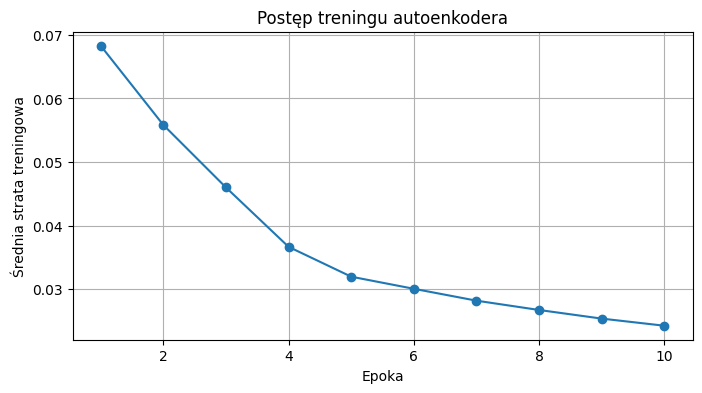

In [27]:
# Trening autoenkodera przez 10 epok i zapis po każdej
device = torch.device("cpu")
autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

num_epochs = 10
log_path = "autoencoder_training_log.csv"
with open(log_path, "w") as f:
    f.write("epoch,avg_train_loss\n")

for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0
    batches = 0

    for imgs_batch, _ in train_loader:
        noise = torch.randn_like(imgs_batch) * 0.1  # szum gaussowski
        noisy_imgs = torch.clamp(imgs_batch + noise, 0., 1.).to(device)
        target = imgs_batch.to(device)
        recon_batch, _ = autoencoder(noisy_imgs)
        loss = criterion(recon_batch, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        batches += 1

    avg_loss = total_loss / batches
    torch.save({
        "epoch": epoch + 1,
        "avg_train_loss": avg_loss,
        "state_dict": autoencoder.state_dict()
    }, f"autoencoder_epoch_last.pth")
    with open(log_path, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f}\n")
    print(f"Epoka {epoch+1}/{num_epochs}  Loss: {avg_loss:.6f}")

    log_df = pd.read_csv(log_path)
    
plt.figure(figsize=(8, 4))
plt.plot(log_df["epoch"], log_df["avg_train_loss"], marker="o")
plt.xlabel("Epoka")
plt.ylabel("Średnia strata treningowa")
plt.title("Postęp treningu autoenkodera")
plt.grid(True)
plt.show()

# Batch do wizualizacji (bez szumu)
autoencoder.eval()
with torch.no_grad():
    imgs, labels = next(iter(train_loader))
    recon, latent = autoencoder(imgs.to(device))


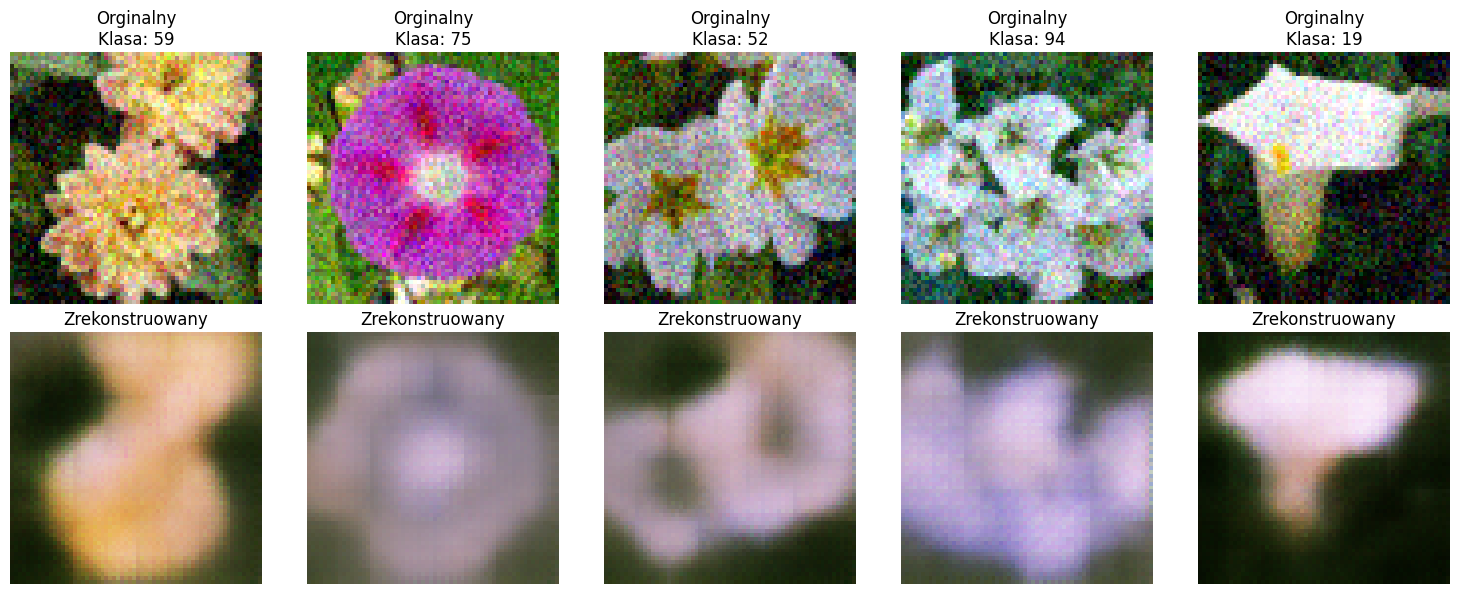

In [28]:
import random

num_samples = 5
indices = random.sample(range(imgs.shape[0]), num_samples)

plt.figure(figsize=(num_samples * 3, 6))
for i, idx in enumerate(indices):
    # Original
    plt.subplot(2, num_samples, i + 1)
    noise = torch.randn_like(imgs[idx]) * 0.1  # szum gaussowski
    imgs[idx] = torch.clamp(imgs[idx] + noise, 0., 1.)
    plt.imshow(imgs[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Orginalny\nKlasa: {labels[idx].item()}")
    plt.axis("off")
    # Reconstructed
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(recon[idx].permute(1, 2, 0).detach().cpu().numpy())
    plt.title("Zrekonstruowany")
    plt.axis("off")
plt.tight_layout()
plt.show()